In [1]:
pip install xgb

ERROR: Could not find a version that satisfies the requirement xgb (from versions: none)
ERROR: No matching distribution found for xgb
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install nixtla

Note: you may need to restart the kernel to use updated packages.


Using transfer methods other methods especially for time series predictions proved to have some bias and were not accurate. So for accuracy we leveraged on NIXTLA TimeGPT model to predict the prices of Rice in Ghana using economic extrogenous features 

# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from nixtla import NixtlaClient
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from utilsforecast.losses import mae
from sklearn.preprocessing import MinMaxScaler





In [5]:
file_path = '/Users/senamdzomeku/Downloads/research/rice prices with exogenous.csv'
df = pd.read_csv(file_path)

# Data Preprocessing / Exploratory Data Analysis

In [6]:
# Convert 'ds' to datetime format (assuming 'MM-YYYY' format)

df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

# Convert to 'YYYY-MM-DD' format, start of the month
df['ds'] = df['ds'].dt.to_period('M').dt.to_timestamp()

In [7]:
eda = df.copy()

In [8]:
eda.set_index('ds', inplace=True)

In [9]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199 entries, 2007-01-01 to 2023-07-01
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   riceusdprice   199 non-null    float64
 1   maizeusdprice  199 non-null    float64
 2   exchangerate   199 non-null    float64
 3   Inflation      199 non-null    float64
 4   Rainfall       199 non-null    float64
dtypes: float64(5)
memory usage: 9.3 KB


# Visualisation/EDA

In [10]:
eda.describe()

,riceusdprice,maizeusdprice,exchangerate,Inflation,Rainfall
count,199.000000,199.000000,199.000000,199.000000,199.000000
mean,55.245394,37.533759,3.831651,19.504045,335.441653
std,14.004332,9.662863,2.754113,12.281528,140.974490
min,33.153808,20.495183,0.921000,8.405687,60.500000
25%,45.190233,30.470422,1.505250,10.798171,218.402767
50%,49.494950,35.937100,3.773800,15.441009,324.388900
75%,66.878801,42.164807,5.425000,20.946911,444.874983
max,84.441483,67.216371,14.400000,55.755276,641.027767


## Plotting features

### Target Variable (Rice Prices)

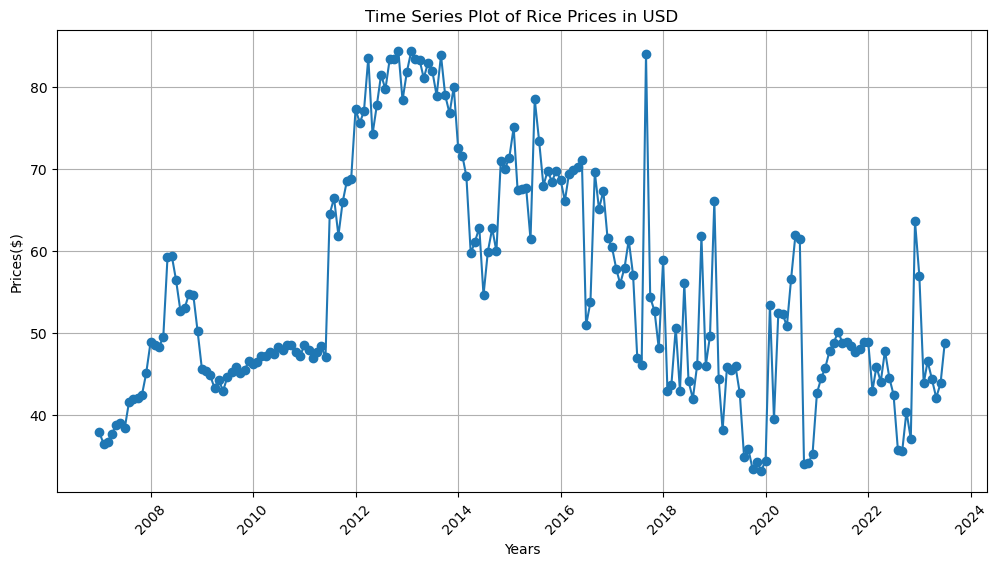

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['riceusdprice'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Prices($)')
plt.title('Time Series Plot of Rice Prices in USD')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


### Maize Prices

Included in analysis because maize is considered a substitute to rice, (demand side factors)

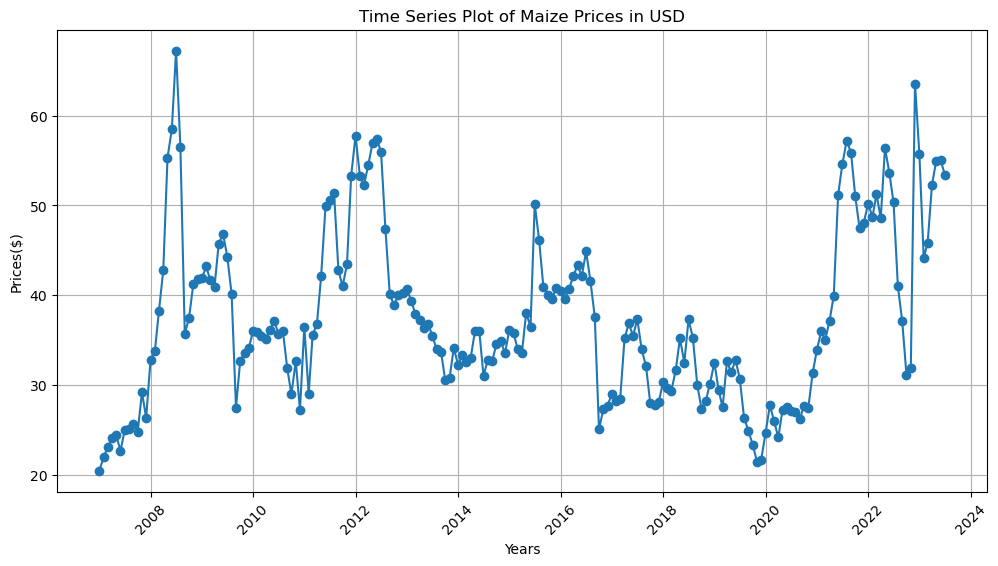

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['maizeusdprice'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Prices($)')
plt.title('Time Series Plot of Maize Prices in USD')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

### Exchange Rate

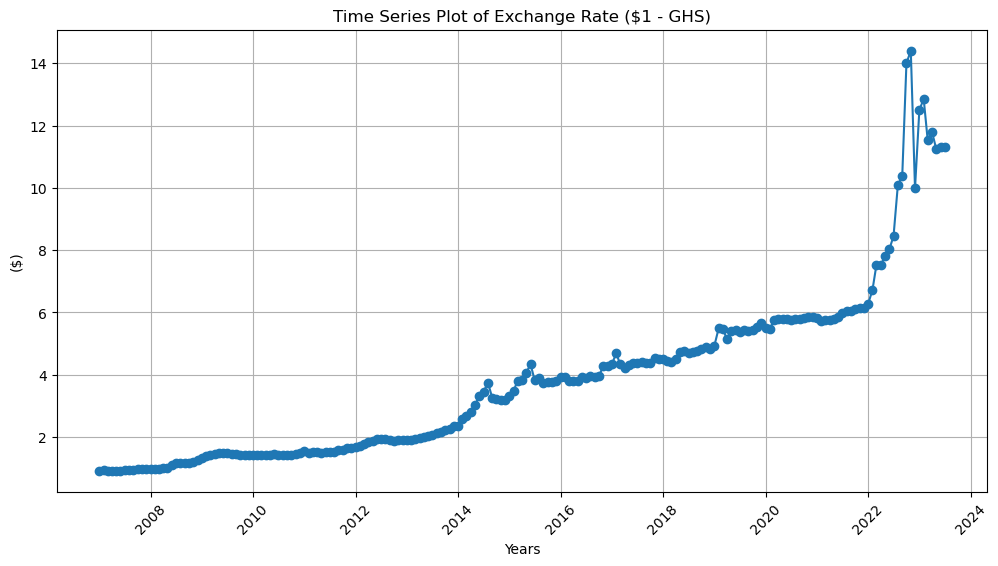

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['exchangerate'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('($)')
plt.title('Time Series Plot of Exchange Rate ($1 - GHS)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

## Inflation Rate

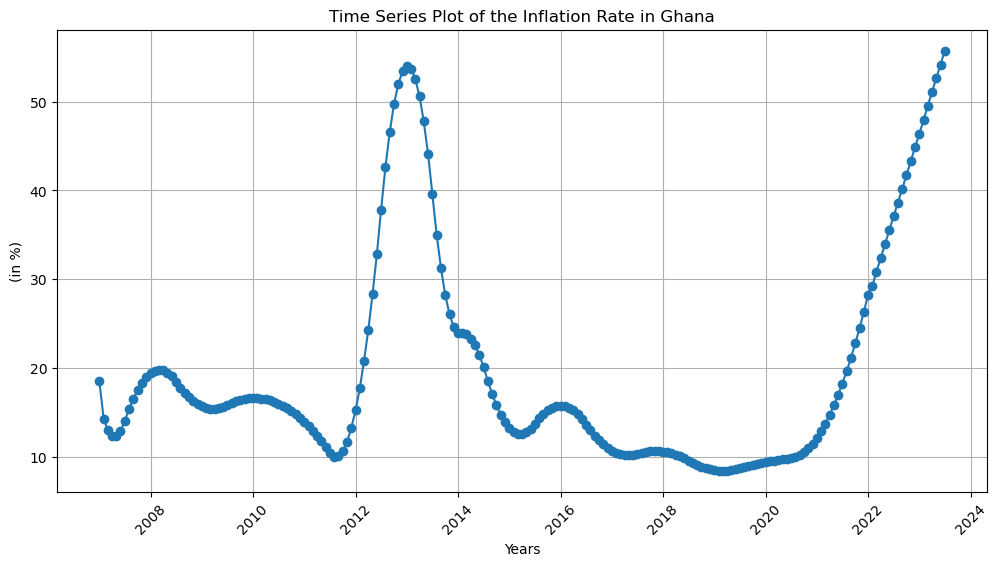

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['Inflation'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('(in %)')
plt.title('Time Series Plot of the Inflation Rate in Ghana')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

## Rainfall

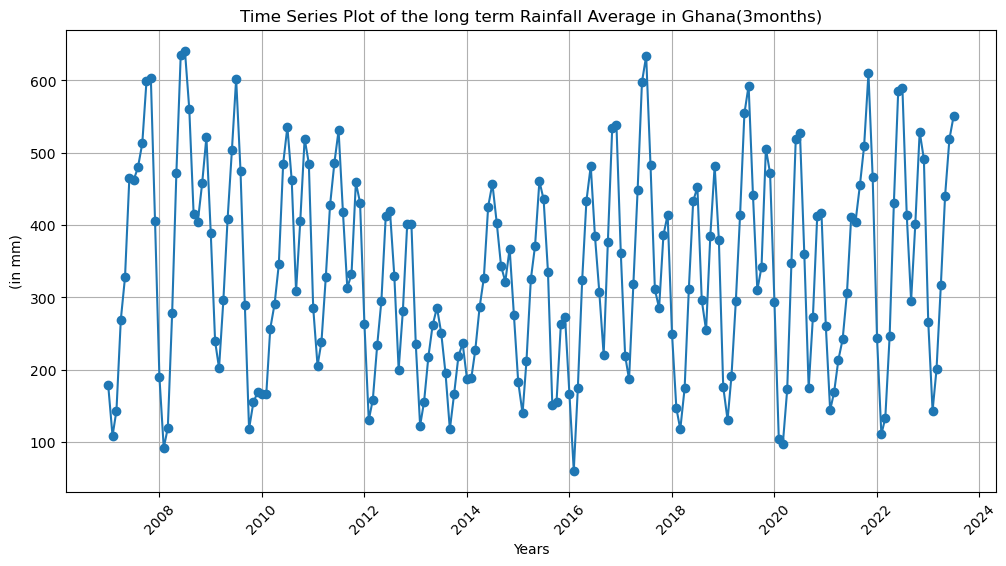

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(eda.index, eda['Rainfall'], marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('(in mm)')
plt.title('Time Series Plot of the long term Rainfall Average in Ghana(3months)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

## Correlation Analysis

In [16]:
# Calculate the correlation matrix
correlation_matrix = df[['riceusdprice', 'maizeusdprice','exchangerate','Inflation','Rainfall']].corr()

print(correlation_matrix)


               riceusdprice  maizeusdprice  exchangerate  Inflation  Rainfall
riceusdprice       1.000000       0.269918     -0.278425   0.316512 -0.208406
maizeusdprice      0.269918       1.000000      0.145797   0.427938  0.186577
exchangerate      -0.278425       0.145797      1.000000   0.318873  0.073237
Inflation          0.316512       0.427938      0.318873   1.000000 -0.050711
Rainfall          -0.208406       0.186577      0.073237  -0.050711  1.000000


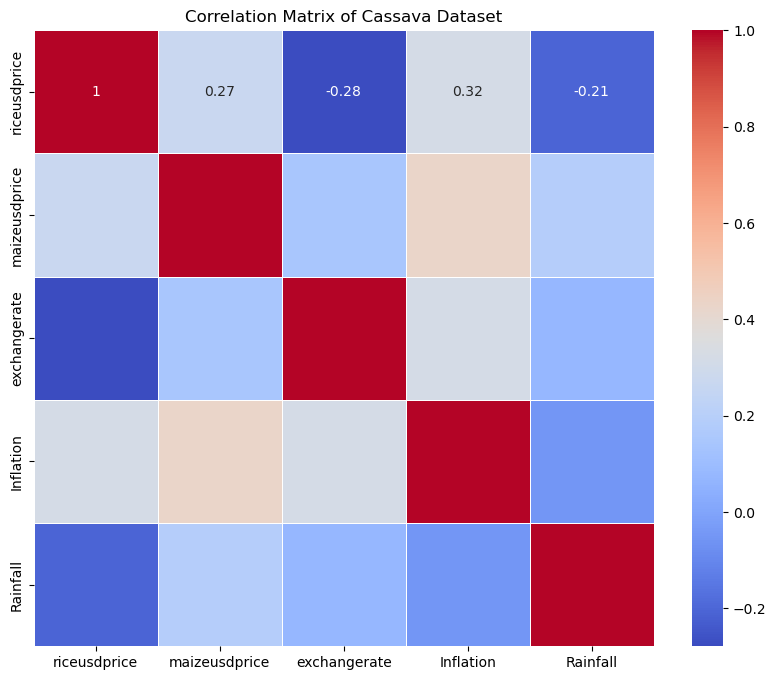

In [17]:

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Cassava Dataset')
plt.show()

From the correlation matrix we see that there is no multicolinearity in the model and all extrogenous features have some correlation to the target variable (riceusdprice)

In [18]:
#function for scaling
def standard_scale_features(df, feature_columns):
    """
    Parameters:
    df (pd.DataFrame):
    feature_columns (list)
    """
    scaler = StandardScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])
    return df

## Using tree models to confirm feature importance

In [19]:
col_scale = ['riceusdprice', 'maizeusdprice', 'exchangerate', 'Inflation','Rainfall']
standard_scale_features (eda,col_scale)

,riceusdprice,maizeusdprice,exchangerate,Inflation,Rainfall
ds,,,,,
2007-01-01,-1.245699,-1.767752,-1.059503,-0.078565,-1.111725
2007-02-01,-1.347244,-1.611380,-1.056409,-0.427832,-1.613471
2007-03-01,-1.327466,-1.498689,-1.057574,-0.529499,-1.364573
2007-04-01,-1.258736,-1.391921,-1.057319,-0.582521,-0.470516
2007-05-01,-1.179242,-1.356333,-1.057101,-0.586899,-0.053908
...,...,...,...,...,...
2023-03-01,-0.624812,0.860623,2.809549,2.450652,-0.959818
2023-04-01,-0.782726,1.532878,2.900551,2.577772,-0.129960
2023-05-01,-0.943091,1.807497,2.700346,2.704892,0.744344


In [20]:
#Splitting features and target
X = eda.drop(columns=['riceusdprice'])
y = eda['riceusdprice']

# Convert feature names to strings
feature_names = [str(name) for name in X.columns]

Using XGboost and Random Tree to assess feature importance

In [21]:
# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, shuffle = False)
xgb_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:15:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "shuffle" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
importances_rf = rf_model.feature_importances_
importances_xgb = xgb_model.feature_importances_

# Create DataFrames for easier comparison
import pandas as pd

# Assuming X_train.columns contains feature names
feature_names = X_train.columns

importances_rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest Importance': importances_rf
}).sort_values(by='Random Forest Importance', ascending=False)

importances_xgb_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost Importance': importances_xgb
}).sort_values(by='XGBoost Importance', ascending=False)


In [23]:
importances_xgb_df

,Feature,XGBoost Importance
1,exchangerate,0.804682
2,Inflation,0.099500
0,maizeusdprice,0.073132
3,Rainfall,0.022686


In [24]:
importances_rf_df

,Feature,Random Forest Importance
1,exchangerate,0.717853
2,Inflation,0.130069
0,maizeusdprice,0.124115
3,Rainfall,0.027963


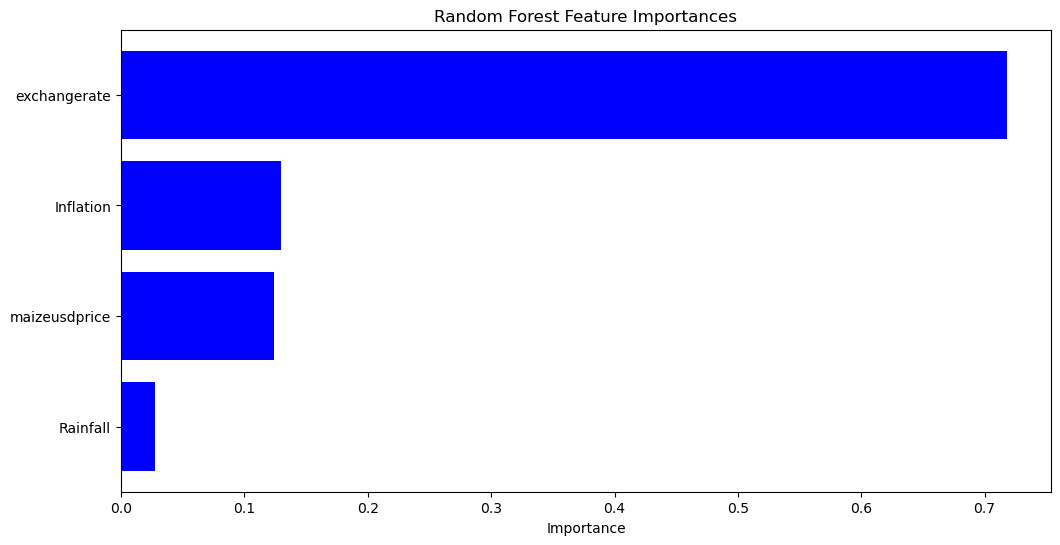

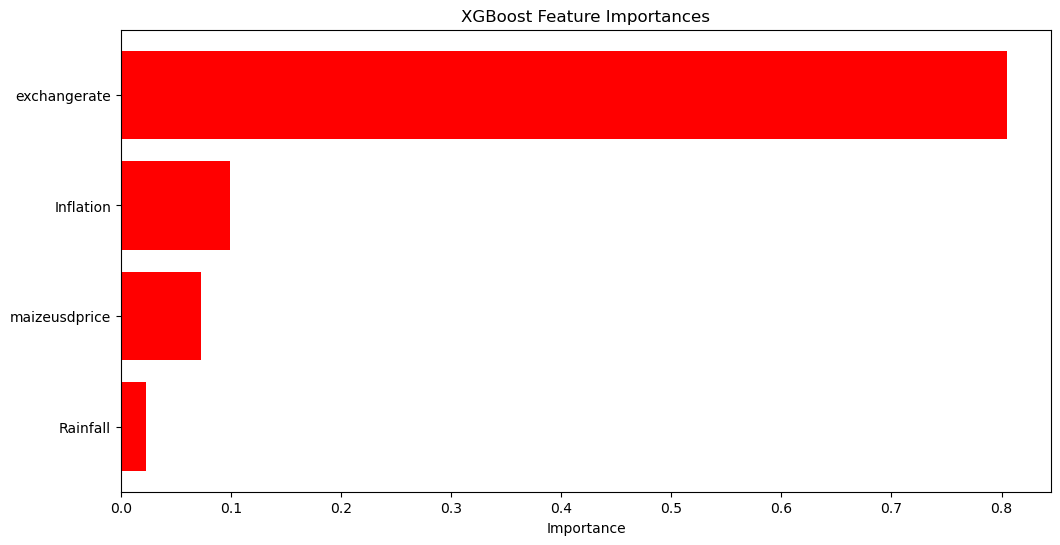

In [25]:
# Plot Random Forest feature importances
plt.figure(figsize=(12, 6))
plt.barh(importances_rf_df['Feature'], importances_rf_df['Random Forest Importance'], color='b')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Plot XGBoost feature importances
plt.figure(figsize=(12, 6))
plt.barh(importances_xgb_df['Feature'], importances_xgb_df['XGBoost Importance'], color='r')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.show()


The results show that Exchange rate is the most important feature, but to confirm we will use the TimeGPT model to confirm

# Functions

In [26]:
def forecast_with_nixtla(client, df, h, exogenous_df):
    forecast = client.forecast(
        df=df,
        h=h,
        target_col='riceusdprice',
        X_df=exogenous_df
    )
    return forecast


In [27]:
def convert_to_start_of_month(df, date_column):
    '''This function is mainly to convert the date column to datetime format'''   
    # Convert the column to datetime format
    df[date_column] = pd.to_datetime(df[date_column], format='%Y-%m-%d')
    
    # Convert to 'YYYY-MM-DD' format, set to the start of the month
    df[date_column] = df[date_column].dt.to_period('M').dt.to_timestamp()
    
    return df

# TimeGPT model



TimeGPT by NIXLA is a powerful forecasting tool that operates through an API, allowing users to make predictions without the need for traditional model training. Unlike other models, where you typically train a model on historical data and then use it to make predictions, TimeGPT combines these steps into one. When you make a request to the TimeGPT API, it processes the data, fine-tunes its pre-trained model if necessary, and returns the forecasts.

This approach simplifies the forecasting process as you don’t need to manage separate training and prediction steps. TimeGPT handles everything in the background, leveraging its pre-trained knowledge on large datasets, and applies fine-tuning based on the specifics of your data if required. This makes it an efficient solution for both short-term and long-term forecasts, depending on the needs.


***Aim is to predict the Rice price from 2023-07 to 2024-07, but data is not available for maize prices and inflation. So to remedy, we would forecast for those extrogenous features and use that for out forecast of mazie prices to allow for explicit prediction.***

In [28]:
nix_df = df.copy()

In [29]:
nix_df

,ds,riceusdprice,maizeusdprice,exchangerate,Inflation,Rainfall
0,2007-01-01,37.844100,20.495183,0.9210,18.541578,179.111133
1,2007-02-01,36.425600,22.002383,0.9295,14.262831,108.555567
2,2007-03-01,36.701883,23.088567,0.9263,13.017348,143.555567
3,2007-04-01,37.661983,24.117650,0.9270,12.367792,269.277767
4,2007-05-01,38.772450,24.460667,0.9276,12.314164,327.861133
...,...,...,...,...,...,...
194,2023-03-01,46.517338,45.828924,11.5500,49.526084,200.472233
195,2023-04-01,44.311413,52.308482,11.8000,51.083382,317.166667
196,2023-05-01,42.071260,54.955418,11.2500,52.640680,440.111133
197,2023-06-01,43.822793,55.113344,11.3250,54.197978,519.027767


### Nixtla API(Azure)

In [30]:
nixtla_client = NixtlaClient(api_key = 'nixtla-tok-AGxYtllDVvOFafOqgELYnxfkJZDTUFgGgK0jEWZWDCfTt2G2b4U7YM1Yd2Svik9PKr914Ef5Ye9Kp7AQ')

from nixtla import TimeGPT

df_maize = nix_df[['ds', 'maizeusdprice']]
df_inf = nix_df[['ds', 'Inflation']]



### Forecasting Extrogenous features 

In [31]:
maize_forecast = nixtla_client.forecast(df=df_maize, h=12, target_col='maizeusdprice')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [32]:
inflation_forecast = nixtla_client.forecast(df=df_inf, h=12, target_col='Inflation')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [33]:
# Rename columns for clarity
maize_forecast = maize_forecast.rename(columns={'TimeGPT': 'maizeusdprice_forecast'})
inflation_forecast = inflation_forecast.rename(columns={'TimeGPT': 'Inflation_forecast'})


In [34]:
# Exchange rate data and Rainfall data for 2023-07 to 2024-07 was available
exchange_rate_actual = pd.read_csv("/Users/senamdzomeku/Downloads/research/exchangerate(2023-8 to 2024-7).csv")

rainfall_actual = pd.read_csv("/Users/senamdzomeku/Downloads/research/rfh3mm(2023-8 to 2024-7).csv")

convert_to_start_of_month(exchange_rate_actual,'ds')


,ds,exchangerate
0,2023-08-01,11.35
1,2023-09-01,11.55
2,2023-10-01,11.88
3,2023-11-01,11.95
4,2023-12-01,11.90
5,2024-01-01,12.30
6,2024-02-01,12.60
7,2024-03-01,13.20
8,2024-04-01,13.62
9,2024-05-01,14.80


In [35]:
convert_to_start_of_month(rainfall_actual,'ds')

,ds,Rainfall
0,2023-08-01,396.916667
1,2023-09-01,447.472233
2,2023-10-01,534.833333
3,2023-11-01,466.583333
4,2023-12-01,311.612500
5,2024-01-01,264.972233
6,2024-02-01,115.194433
7,2024-03-01,133.638900
8,2024-04-01,230.444433
9,2024-05-01,398.888867


In [36]:
convert_to_start_of_month(maize_forecast,'ds')

,ds,maizeusdprice_forecast
0,2023-08-01,48.955544
1,2023-09-01,47.431839
2,2023-10-01,45.445816
3,2023-11-01,44.532730
4,2023-12-01,48.592476
5,2024-01-01,48.660427
6,2024-02-01,46.452076
7,2024-03-01,48.442429
8,2024-04-01,48.314266
9,2024-05-01,52.092049


In [37]:
convert_to_start_of_month(inflation_forecast,'ds')

,ds,Inflation_forecast
0,2023-08-01,58.329655
1,2023-09-01,59.633240
2,2023-10-01,61.103840
3,2023-11-01,62.648777
4,2023-12-01,63.954609
5,2024-01-01,65.577896
6,2024-02-01,66.907761
7,2024-03-01,68.602654
8,2024-04-01,69.553314
9,2024-05-01,70.800751


In [38]:
# Merge forecasts

X_df = maize_forecast.merge(inflation_forecast, on='ds').merge(exchange_rate_actual, on='ds').merge(rainfall_actual, on='ds')

# Convert 'ds' to datetime format (assuming 'MM-YYYY' format)
X_df['ds'] = pd.to_datetime(X_df['ds'], format='%Y-%m-%d')

In [39]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ds                      12 non-null     datetime64[ns]
 1   maizeusdprice_forecast  12 non-null     float64       
 2   Inflation_forecast      12 non-null     float64       
 3   exchangerate            12 non-null     float64       
 4   Rainfall                12 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 612.0 bytes


### Forecasting Target Variable

In [40]:
# Define the forecast horizon
forecast_horizon = 12


# Create future dates for extrogenous table predicting future maize prices(essentially the horizon/length of prediction in months)
last_date = nix_df['ds'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')


In [41]:
future_dates

DatetimeIndex(['2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', freq='M')

In [42]:
# Extract forecasted values from X_df 
maize_forecast = X_df['maizeusdprice_forecast'].values  
exchangerate_actual = X_df['exchangerate'].values 
inflation_forecast = X_df['Inflation_forecast'].values  
rainfall_actual = X_df['Rainfall'].values 

# Create DataFrame with future dates and forecasted values
forecast_exogenous_df = pd.DataFrame({
    'ds': future_dates,
    'maizeusdprice': maize_forecast,
    'exchangerate': exchangerate_actual,
    'Inflation': inflation_forecast,
    'Rainfall' : rainfall_actual
})

# Convert 'ds' to datetime format (assuming 'MM-YYYY' format)
forecast_exogenous_df['ds'] = pd.to_datetime(forecast_exogenous_df['ds'], format='%Y-%m-%d')

# Convert to 'YYYY-MM-DD' format, start of the month
forecast_exogenous_df['ds'] = forecast_exogenous_df['ds'].dt.to_period('M').dt.to_timestamp()

In [43]:
forecast_exogenous_df

,ds,maizeusdprice,exchangerate,Inflation,Rainfall
0,2023-08-01,48.955544,11.35,58.329655,396.916667
1,2023-09-01,47.431839,11.55,59.633240,447.472233
2,2023-10-01,45.445816,11.88,61.103840,534.833333
3,2023-11-01,44.532730,11.95,62.648777,466.583333
4,2023-12-01,48.592476,11.90,63.954609,311.612500
5,2024-01-01,48.660427,12.30,65.577896,264.972233
6,2024-02-01,46.452076,12.60,66.907761,115.194433
7,2024-03-01,48.442429,13.20,68.602654,133.638900
8,2024-04-01,48.314266,13.62,69.553314,230.444433
9,2024-05-01,52.092049,14.80,70.800751,398.888867


In [44]:
nix_df = nix_df.rename(columns={'riceusdprice': 'y'})

In [45]:
# historical data 
df_main = nix_df[['ds', 'y', 'maizeusdprice', 'exchangerate', 'Inflation','Rainfall']]

In [46]:
# renaming target to y
df_main = df_main.rename(columns={'riceusdprice': 'y'})

***Forecasting (Training/Prediction)***

In [47]:
timegpt_forecast = nixtla_client.forecast(df=df_main, X_df=forecast_exogenous_df, h=12, level=[80, 90])


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Using the following exogenous variables: maizeusdprice, exchangerate, Inflation, Rainfall
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [48]:
timegpt_forecast

,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,2023-08-01,44.322246,34.004847,35.249701,53.394792,54.639646
1,2023-09-01,42.999340,27.713112,30.716568,55.282112,58.285567
2,2023-10-01,40.191036,24.625175,26.550241,53.831830,55.756897
3,2023-11-01,40.149592,22.909544,25.424034,54.875149,57.389639
4,2023-12-01,43.584680,24.511360,27.127858,60.041503,62.658001
5,2024-01-01,44.962418,24.707117,28.343957,61.580878,65.217718
6,2024-02-01,43.605569,22.571214,32.065898,55.145240,64.639925
7,2024-03-01,43.378791,26.236465,31.153473,55.604110,60.521118
8,2024-04-01,43.408463,20.037389,33.140459,53.676467,66.779537
9,2024-05-01,45.253228,24.013091,29.796192,60.710264,66.493364


In [49]:
# Time GPT has some formalities requiring a unique_id column and ds for date columns
timegpt_forecast['unique_id']='GH'

In [50]:
nix_df['unique_id']='GH'

TimeGPT_lo_90: This represents the lower bound of the 90% confidence interval. It indicates that there is a 90% chance that the true value will be above this value.

TimeGPT_hi_90: This represents the upper bound of the 90% confidence interval. It indicates that there is a 90% chance that the true value will be below this value.

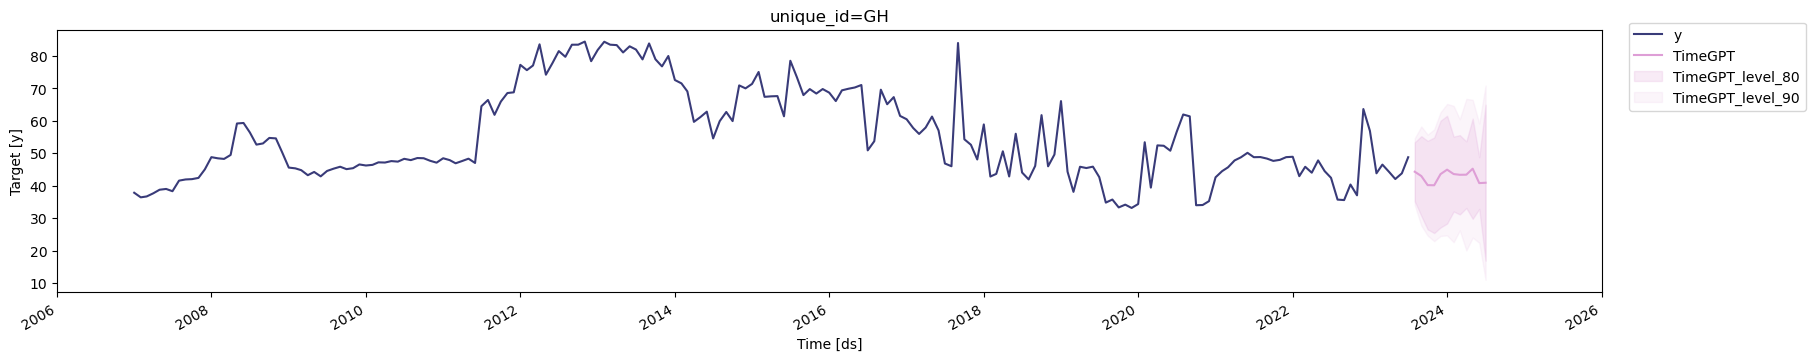

In [51]:
#Visualizing predictions
nixtla_client.plot(
    nix_df[['unique_id', 'ds', 'y']], 
    timegpt_forecast, 
    max_insample_length=365, 
    level=[80, 90], 
)

### Saving forecasts

In [52]:
#change date column to datetime format
timegpt_forecast=convert_to_start_of_month(timegpt_forecast, 'ds')

In [53]:
# Rename the forecasted target column for clarity
timegpt_forecast = timegpt_forecast.rename(columns={'TimeGPT': 'y'})

In [54]:
# Combine forecasted target with forecasted exogenous variables
forecast_combined_df = forecast_exogenous_df.merge(timegpt_forecast[['ds', 'y']], on='ds')

# save to csv
forecast_combined_df.to_csv('forecast_combined_df.csv', index=False)

In [55]:

forecast_combined_df['unique_id'] =  "GH"

### Important Features

<Axes: ylabel='features'>

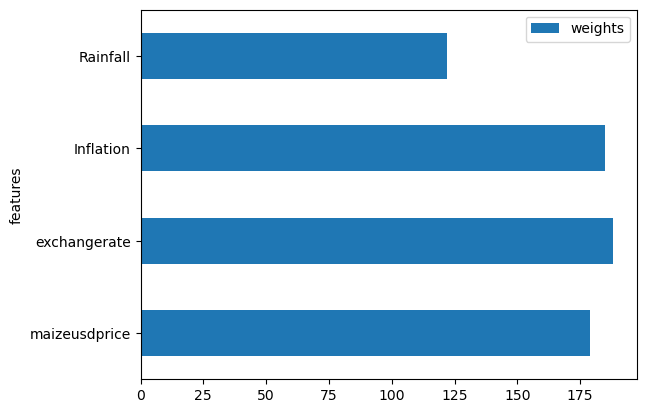

In [56]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

***Exchange rate is the most important feature, confirming it again***

## Tests

Investigating how model perform with already existing data 

In [57]:
y07_y22 = nix_df[(nix_df['ds'] >= '2007-01-01') & (nix_df['ds'] <= '2022-12-31')]

Split into train(historical) and test(future)

In [58]:
#historical data
y07_y21 = y07_y22[(y07_y22['ds'] >= '2007-01-01') & (y07_y22['ds'] <= '2021-12-31')]


In [59]:
#future data(1 year)
y22_y22 = y07_y22[(y07_y22['ds'] >= '2022-01-01') & (y07_y22['ds'] <= '2022-12-31')]

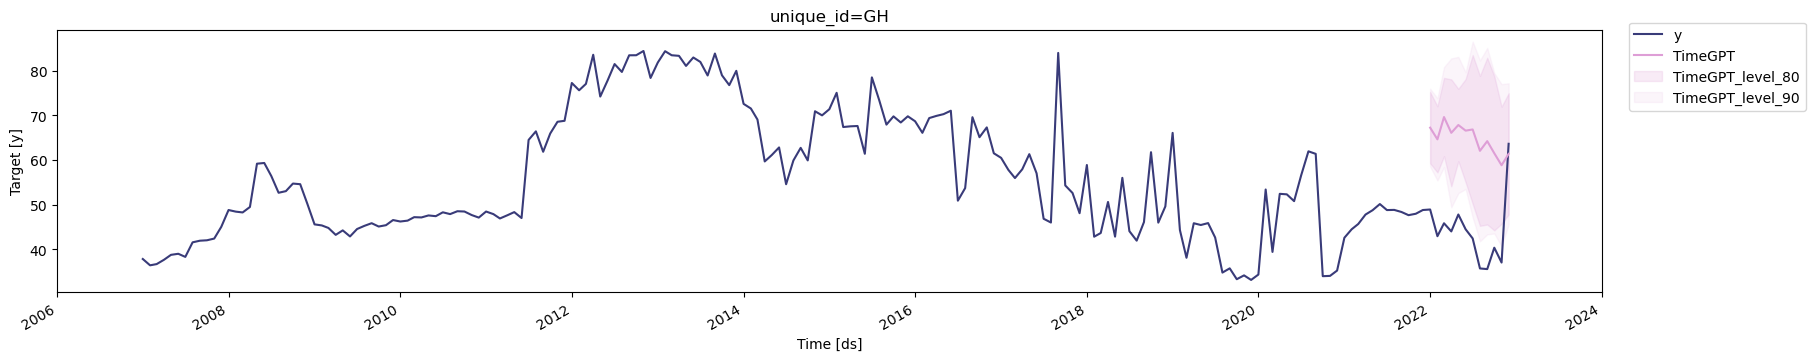

In [63]:


nixtla_client.plot(
    y07_y22[['unique_id', 'ds', 'y']], 
    timegpt_forecast1, 
    max_insample_length=365, 
    level=[80, 90], 
)

In [64]:
timegpt_forecast1

,unique_id,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,GH,2022-01-01,67.260465,58.530994,59.291058,75.229872,75.989935
1,GH,2022-02-01,64.647180,55.430775,57.244833,72.049527,73.863585
2,GH,2022-03-01,69.638858,58.447609,60.863112,78.414603,80.830107
3,GH,2022-04-01,66.105752,49.428974,54.130123,78.081382,82.782530
4,GH,2022-05-01,67.856132,52.590081,59.753852,75.958411,83.122183
5,GH,2022-06-01,66.596553,53.527023,55.038173,78.154933,79.666082
6,GH,2022-07-01,66.859112,47.171741,50.188558,83.529666,86.546483
7,GH,2022-08-01,62.073970,41.818447,45.274328,78.873613,82.329494
8,GH,2022-09-01,64.244904,43.362500,45.566298,82.923511,85.127309
9,GH,2022-10-01,61.529446,43.555853,44.268068,78.790824,79.503039


# Fine tuning


In [65]:
testd = nix_df[-24:]            
input_seq = nix_df[:-24] 

In [66]:
testd 


,ds,y,maizeusdprice,exchangerate,Inflation,Rainfall,unique_id
175,2021-08-01,48.843042,57.189769,6.040,19.634017,404.944433,GH
176,2021-09-01,48.372817,55.879754,6.050,21.137773,454.888900,GH
177,2021-10-01,47.663308,51.047985,6.110,22.748613,509.222233,GH
178,2021-11-01,47.978858,47.456400,6.135,24.466538,609.611133,GH
179,2021-12-01,48.816815,48.097840,6.150,26.291548,466.361100,GH
180,2022-01-01,48.930931,50.201780,6.275,28.223642,244.611133,GH
181,2022-02-01,42.947918,48.708754,6.725,29.281212,110.666667,GH
182,2022-03-01,45.845350,51.271215,7.525,30.838509,133.361100,GH
183,2022-04-01,44.021250,48.626015,7.525,32.395807,246.583333,GH
184,2022-05-01,47.812533,56.400454,7.800,33.953105,429.944433,GH


In [67]:
fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=len(testd),
    level=[90],
    finetune_steps=12,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


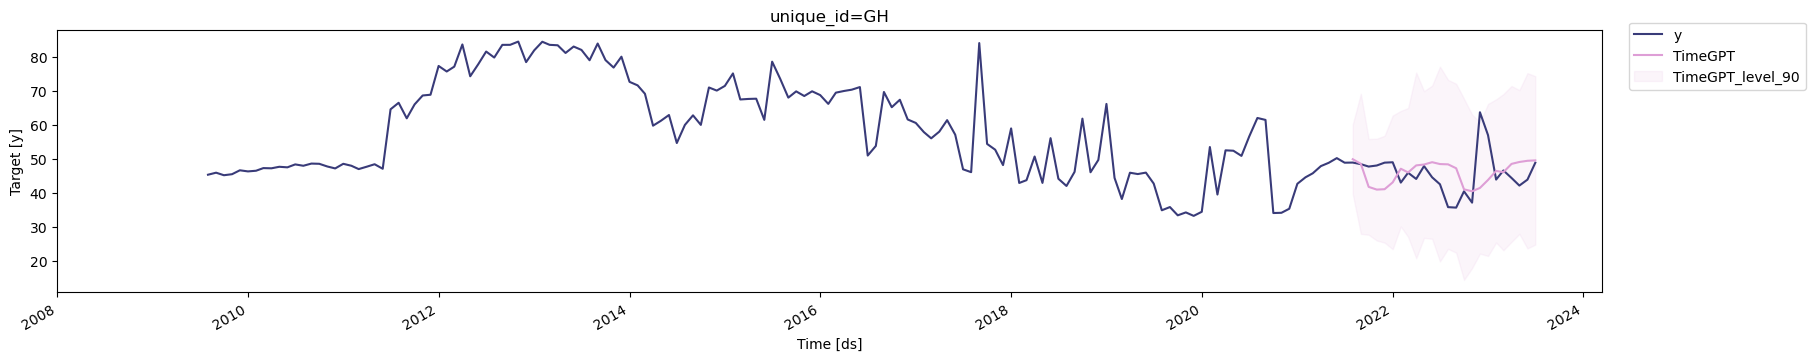

In [68]:
nixtla_client.plot(nix_df[-168:], fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [69]:
test = testd.copy()
test['unique_id'] = 'GH'

test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

In [70]:
evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')

evaluation

,unique_id,TimeGPT
0,GH,5.451618


Mean absolute error of 5.548

In [71]:
# Define range for finetune_steps
finetune_steps_range = [10,11,12,13,14,15,16,17,18,19, 20]  # Adjust this range as needed

# Storage for results
results = []

for steps in finetune_steps_range:
    print(f"Testing finetune_steps={steps}...")
    
    # Perform forecasting
    fcst_df = nixtla_client.forecast(
        df=input_seq,
        h=len(testd),
        level=[90],
        finetune_steps=steps,
        finetune_loss='mae',
        model='timegpt-1-long-horizon',
        time_col='ds',
        target_col='y'
    )
    
    # Prepare test data for evaluation
    test = testd.copy()
    test['unique_id'] = 'GH'
    test['TimeGPT'] = fcst_df['TimeGPT'].values
    
    # Evaluate the forecast
    evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')
    
    # Store the results
    results.append({'finetune_steps': steps, 'evaluation': evaluation})
    print(f"Evaluation for finetune_steps={steps}: {evaluation}")



INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Testing finetune_steps=10...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=10:   unique_id   TimeGPT
0        GH  5.550708
Testing finetune_steps=11...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=11:   unique_id   TimeGPT
0        GH  5.491914
Testing finetune_steps=12...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=12:   unique_id   TimeGPT
0        GH  5.451618
Testing finetune_steps=13...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=13:   unique_id   TimeGPT
0        GH  5.413028
Testing finetune_steps=14...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=14:   unique_id   TimeGPT
0        GH  5.384813
Testing finetune_steps=15...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=15:   unique_id   TimeGPT
0        GH  5.364401
Testing finetune_steps=16...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=16:   unique_id   TimeGPT
0        GH  5.343118
Testing finetune_steps=17...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=17:   unique_id   TimeGPT
0        GH  5.336183
Testing finetune_steps=18...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=18:   unique_id  TimeGPT
0        GH  5.32992
Testing finetune_steps=19...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: MS


Evaluation for finetune_steps=19:   unique_id   TimeGPT
0        GH  5.321045
Testing finetune_steps=20...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Evaluation for finetune_steps=20:   unique_id   TimeGPT
0        GH  5.322408


***19 fine tune steps are optimal***